# 1- Introduction

In this notebook, we will demonstrate how to use the akward table and how to build selector efficiently using lambda's in python

In [1]:
import uproot
import awkward as ak
import numpy as np
import math
import hist
import matplotlib.pyplot as plt
import os
import subprocess
import vector
import gc

First we need to identify the akward table as vectors

In [80]:
vector.register_awkward() 

We then collect the data (either MC or real data)

In [81]:
DATATYPE="mc"
assert((DATATYPE=="mc") or (DATATYPE=="data"))
BASEDIR="/pbs/throng/training/nantes-m2-rps-exp/data" # basedir where to look for runXXX.DATATYPE.root files
IS_MC=True if DATATYPE=="mc" else False

In [82]:
def data_file_path(run,is_mc=IS_MC,dest=BASEDIR):
    datatype="mc" if is_mc else "data"
    print({dest},"/run",{run},".",{datatype},".root")
    return f"{dest}/run{run}.{datatype}.root"

In [83]:
SAMPLE_RUNS=[291694,291399]

Let's now open the root file and print the content

In [84]:
file = uproot.open(data_file_path(SAMPLE_RUNS[0],IS_MC))
events = file["eventsTree"]
eventsGen = file["genTree"]
events.show()
eventsGen.show()

{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {291694} . {'mc'} .root
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
runNumber            | int32_t                  | AsDtype('>i4')
xVtx                 | double                   | AsDtype('>f8')
yVtx                 | double                   | AsDtype('>f8')
zVtx                 | double                   | AsDtype('>f8')
isCINT               | bool                     | AsDtype('bool')
isCMSL               | bool                     | AsDtype('bool')
isCMSH               | bool                     | AsDtype('bool')
isCMLL               | bool                     | AsDtype('bool')
isCMUL               | bool                     | AsDtype('bool')
nMuons               | int32_t                  | AsDtype('>i4')
Muon_E               | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
Muon_Px              | st

We will just print here the number of entries (events) in the file for the record

In [85]:
print(events.num_entries)
print(eventsGen.num_entries)

40000
40000


# 2- 4-momentum vector with akward and selectors

It is possible to build akward table as a 4-momentum vector. To do that, you need to use the "zip" method whith px, py, pz and E as its 4 first members. You also need to call this table with the following specific name "Momentum4D"

This allow you in the following to get the kinematics of your tracks quite easily by calling:
- .p, .px, .py, .pz, .pt, ... for the momentum
- .eta for the pseudo-rapidity
- ...

Indeed, you can also add more information to the akward table after defining the first 4 members of the table (as you can see below)

We are here implementing a "getTracks" function that will be use in the following to select tracks. See here:

In [86]:
def getTracks(events):
    return ak.zip({"px":events["Muon_Px"],
                       "py":events["Muon_Py"],
                       "pz":events["Muon_Pz"],
                       "E":events["Muon_E"],
                       "charge":events["Muon_Charge"],
                       "thetaAbs":events["Muon_thetaAbs"],
                       "matched":events["Muon_matchedTrgThreshold"],
                       "n":events["nMuons"]},
                    with_name='Momentum4D')

def getTracksGen(events):
    return ak.zip({"px":events["Muon_GenPx"],
                    "py":events["Muon_GenPy"],
                    "pz":events["Muon_GenPz"],
                    "E":events["Muon_GenE"],
                    "n":events["nMuonsGen"],
                    "label":events["Muon_GenLabel"],
                    "mother":events["Muon_GenMotherPDGCode"]},
                    with_name='Momentum4D')

Now we will design a function to run over the data with uproot. 
In the iterate, we define all the varaible we want to access for each events

We first select good events and track using lambdas in python. What is a good event or a good track will be define later when we call the function "scan"

In [87]:
#########
# My code
#########

def invariant_mass(pT1,pT2,eta1,eta2,phi1,phi2):
    return np.sqrt(2*pT1*pT2*(np.cosh(eta1-eta2)-np.cos(phi1-phi2)))

#def invariant_mass(E1,E2,p1,p2):
#    return np.sqrt(2*pT1*pT2*(np.cosh(eta1-eta2)-np.cos(phi1-phi2)))

def combinations(x):
    idx = np.stack(np.triu_indices(len(x), k=1), axis=-1)
    return x[idx]
combinations(np.arange(3))


array([[0, 1],
       [0, 2],
       [1, 2]])

In [88]:
print(dir(vector.backends.awkward.MomentumArray4D))

['E', 'E2', 'Et', 'Et2', 'GenericClass', 'M', 'M2', 'Mask', 'Mt', 'Mt2', 'ProjectionClass2D', 'ProjectionClass3D', 'ProjectionClass4D', '__abs__', '__abstractmethods__', '__add__', '__and__', '__annotations__', '__array__', '__array_function__', '__array_ufunc__', '__arrow_array__', '__bool__', '__bytes__', '__cast_cpp__', '__class__', '__class_getitem__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__divmod__', '__doc__', '__eq__', '__floordiv__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__ilshift__', '__imatmul__', '__imod__', '__imul__', '__init__', '__init_subclass__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__lshift__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__'

In [89]:
import pandas
l1 = pandas.read_csv('../data/counters.offline.csv')['run']
l2 = [int(e) for e in os.popen("ls /pbs/throng/training/nantes-m2-rps-exp/data/ | grep 'mc' | cut -c 4-9").read().split('\n')[0:-2]]
#list(set(l1) & set(l2))

In [90]:
def invariant_mass(part1,part2):
    # sum impulsions
    px = part1.px+part2.px
    py = part1.py+part2.py
    pz = part1.pz+part2.pz 
    E1 = part1.e
    E2 = part2.e
    return np.sqrt((E1+E2)**2-(px**2+py**2+pz**2))

In [91]:
def scanGen(dataDescription, 
              #hMag:hist.Hist, hPhi:hist.Hist, hMinv:hist.Hist,
              eventSelector=lambda x:[True]*len(x),
              trackSelector=lambda x:[True]*len(x), 
              verbose:bool=False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
    """
    
    for batch in uproot.iterate(dataDescription,
                                ["nMuonsGen","Muon_GenPx","Muon_GenPy","Muon_GenPz","Muon_GenE","Muon_GenLabel","Muon_GenMotherPDGCode"],                                
                                 report=True):

        events=batch[0] # batch[1] is the report info
        if len(events) < 1000:
            print("something is wrong",batch[1]) # this is a protection for some corrupted input data files 
            break
            
        goodEvents = events[eventSelector(events)] 
        tracks = getTracksGen(events)
        goodTracks=tracks[trackSelector(tracks)]
        t = goodTracks  # notation
         
        # JPsi 443
        
        #print(t)
        
        NgenJPsi = ak.sum(1*t.mother==443)/2
        NgenJPsiN = NgenJPsi/len(t)
        
        if verbose:
            print(batch[1])
        gc.collect()

        return NgenJPsiN



In [92]:
# Ordre de grandeur
#Aeps = 0.2386
#sigmaJPsi = Nraw*A/(Aeps*5.94)

In [235]:
def scan(dataDescription,
            fminv,
            eventSelector=lambda x:[True]*len(x),
            trackSelector=lambda x:[True]*len(x), 
            verbose:bool=False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
    """
    


    
    for batch in uproot.iterate(dataDescription,
                                ["isCINT","isCMUL","isCMSL","nMuons","Muon_Px","Muon_Py","Muon_Pz","Muon_E","Muon_Charge","Muon_thetaAbs","Muon_matchedTrgThreshold"],                                
                                 report=True):
        events=batch[0] # batch[1] is the report info
        if len(events) < 1000:
            print("something is wrong",batch[1]) # this is a protection for some corrupted input data files 
            break
            
        goodEvents = events[eventSelector(events)] 
        tracks = getTracks(events)
        goodTracks=tracks[trackSelector(tracks)]
        t = goodTracks  # notation
         
        #hMag.fill(ak.flatten(t.p))
        #hPhi.fill(ak.flatten(t.phi))

        # Keep events with n>=2
        n = ak.num(t.charge,axis=1)
        tsel = t[n==2]
        
        # Combinations
        C = ak.combinations(tsel,2)
        
        # Keep opposite charges only    
        I = (C["0"].charge+C["1"].charge)==0
        
        # Compute invariant mass
        
        minv = invariant_mass(C["0"][I],C["1"][I])
        
        # Save all minv
        np.save(fminv,ak.flatten(minv).to_numpy())
        
        
        #hMinv.fill(ak.flatten(minv))
        
        # Simple integral
        #Nraw = ak.sum(1*(2.7<minv)*(minv<3.4))
        
        # JPsi: 100140, Psi2s: 49860
        #print("A.eps=",(Nraw/len(events))/(100140/150000))
        #print(ak.sum([]))
        
        #NrawN = Nraw/len(events)
        
        #print(C["0"])
        #print(len(C),len(Csel))
        #Ccharge = ak.combinations(tsel.charge,2)
        #print((ak.to_layout(Ccharge)[0][0]))
        #print(ak.sum(Ccharge,axis=1))
        #print(C)
        #print(ak.num(tsel,axis=1))
        
        
        
        #invariant_mass(E1,E2,p1,p2)
        #hMinv
        #print(type(goodTracks))
        #print(dir(vector.backends.awkward.MomentumArray4D))
        #print((goodTracks.p))
        
        
        
        if verbose:
            print(batch[1])
        gc.collect()



We define now some histograms that we want to plot and run over the data. We do it twice for illustration purposes:
- first, we don't give any definition for the eventselector and track selector. This is equivalent to say that all events and all tracks are good
- second, we implement some definition for the lambda function to have some selection criteria on our tracks


In [271]:
%%time
## SINGLE MUON TRACK PLOTS
#No cuts

#scan(dataDescription=f"{BASEDIR}/run*.{DATATYPE}.root:eventsTree",
#          hMag=vhMagRaw, hPhi=vhPhiRaw)

#runid = "2904[1-3]*"
runid = "*"
'''
NgenN = scanGen(dataDescription=f"{BASEDIR}/run{runid}.mc.root:genTree",
          #hMag=vhMagEvSel, hPhi=vhPhiEvSel, hMinv=vhMinvEvSel,
          #eventSelector=lambda x: x["isCMUL"]==True,
          #trackSelector=lambda x: (x.p>5) & (x.eta>-4),
         verbose=True
    )
'''
os.system("> minv.dat")
f = open("minv.npy","ab")
scan(dataDescription=f"{BASEDIR}/run{runid}.data.root:eventsTree",
        fminv=f,
        eventSelector=lambda x: x["isCMUL"]==True,
        #trackSelector=lambda x: (x.p>5) & (x.eta>-4),
        verbose=True
    )
f.close()

#print(NrawN/NgenN)

<Report start=0 stop=668105 source='/pbs/throng/training/nantes-m2-rps-exp/data/run290428.data.root:/eventsTree;1'>
<Report start=668105 stop=2357952 source='/pbs/throng/training/nantes-m2-rps-exp/data/run291447.data.root:/eventsTree;1'>
<Report start=2357952 stop=4950944 source='/pbs/throng/training/nantes-m2-rps-exp/data/run290860.data.root:/eventsTree;1'>
<Report start=4950944 stop=7220676 source='/pbs/throng/training/nantes-m2-rps-exp/data/run290860.data.root:/eventsTree;1'>


/pbs/throng/training/nantes-m2-rps-exp/miniconda3/envs/qqbar2mumu/lib/python3.9/site-packages/awkward/_connect/numpy.py:391: RuntimeWarning: invalid value encountered in sqrt
  result = impl(*args, **kwargs)


<Report start=7220676 stop=9748758 source='/pbs/throng/training/nantes-m2-rps-exp/data/run292062.data.root:/eventsTree;1'>
<Report start=9748758 stop=11212400 source='/pbs/throng/training/nantes-m2-rps-exp/data/run292062.data.root:/eventsTree;1'>
<Report start=11212400 stop=13726429 source='/pbs/throng/training/nantes-m2-rps-exp/data/run291453.data.root:/eventsTree;1'>
<Report start=13726429 stop=15469803 source='/pbs/throng/training/nantes-m2-rps-exp/data/run291453.data.root:/eventsTree;1'>
<Report start=15469803 stop=17107977 source='/pbs/throng/training/nantes-m2-rps-exp/data/run291944.data.root:/eventsTree;1'>
<Report start=17107977 stop=18420565 source='/pbs/throng/training/nantes-m2-rps-exp/data/run290467.data.root:/eventsTree;1'>
<Report start=18420565 stop=18850601 source='/pbs/throng/training/nantes-m2-rps-exp/data/run290401.data.root:/eventsTree;1'>
<Report start=18850601 stop=21433043 source='/pbs/throng/training/nantes-m2-rps-exp/data/run291041.data.root:/eventsTree;1'>
<Re

In [2]:
nbin = 200
minvmin = 1.0
minvmax = 5.0
hminv = hist.Hist(hist.axis.Regular(bins=nbin,start=minvmin,stop=minvmax,name='$m\mu\mu$'))

f = open('minv.npy', 'rb')
for i in range(166):
    A = np.load(f)
    #print(A)
    hminv.fill(A)
f.close()

In [335]:
#####
# Fit
#####
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def bgVWG(x, N, mu, alpha, beta):
    X = (x-mu)/mu
    sig = alpha + beta*X
    return N*np.exp(-(x-mu)**2/(2*sig**2))

def bgPL(x, N, mu, a1, a2, a3):
    return N*(1+a1*x)/(a2*x+a3*x)
    #return N*(a1*x**2+a2*x+a3)  # test
    
def bgDE(x, N, a1, a2, a3):
    return N*(np.exp(a1*x) + a3*np.exp(a2*x))


def crystalball(x, N, mu, sig, alphaL, nL, alphaR, nR):
    AL = ( nL / np.absolute( alphaL ) )**nL * np.exp( -1 * np.absolute( alphaL )**2 / 2 )
    AR = ( nR / np.absolute( alphaR ) )**nR * np.exp( -1 * np.absolute( alphaR )**2 / 2 )
    BL = nL / np.absolute( alphaL ) - np.absolute( alphaL )
    BR = nR / np.absolute( alphaR ) - np.absolute( alphaR )

    result = np.zeros(np.size(x))
    
    rel = ( x - mu )/sig
    I1 = rel < -1 * alphaL
    I2 = (rel >= -1 * alphaL) * (rel <= alphaR)
    I3 = rel > alphaR
    result[I1] = AL * (BL - rel[I1])**(-nL)
    result[I2] = np.exp(-1 * rel[I2]**2 / 2)
    result[I3] = AR*(BR + rel[I3])**(-nR)
        
    return result * N #/ (np.sqrt(2 * np.pi) * sig)

def fitfunc(x, N, mu, sig, alphaL, nL, alphaR, nR,   Nbg, a1, a2, a3):
    return crystalball(x, N, mu, sig, alphaL, nL, alphaR, nR) + bgDE(x, Nbg, a1, a2, a3)


# Fit minv interval
xmin = minvmin
xmax = minvmax
# Get data from histo
y,x = hminv[xmin*1j:xmax*1j].to_numpy()
x = x[:-1]+(x[1]-x[0])/2
xminpeak = 2.5
xmaxpeak = 4
# Fit bg
Ipeak = (xminpeak<x)*(x<xmaxpeak)
Ibg = ~Ipeak
err = 1*np.sqrt(y)
 
paramsbg, covsbg = curve_fit(bgDE, x[Ibg], np.log(y[Ibg]), method='trf')
# Fit peak
#params, covs = curve_fit(fitfunc, x, np.log(y), p0=[1000, 3.1, 0.7, 10, 3, 1, 3, *paramsbg], method='trf')

#print("params: ", paramsbg)
print("params: ", params) 
#print("covariance: \n", covs) 

params:  [ 9.99816277e+02  2.89000055e+00  1.34616879e-07  1.00000000e+01
  3.00000000e+00  5.92022582e-01  5.35265688e-01  1.33043360e+01
 -1.25880172e-01  5.10692579e-01 -2.03436382e-03]


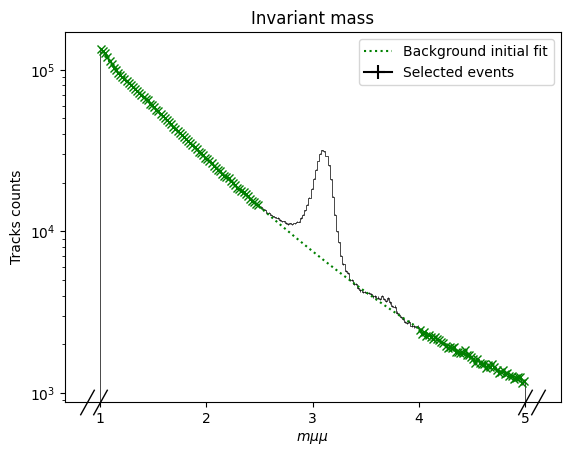

In [337]:
#vhMagRaw.plot(label="no cuts")
hminv.plot(label="Selected events",color='black',ls='-',lw=0.5)

# Initial bg fit
if 1:
    plt.plot(x[Ibg],y[Ibg],'xg')
    yfitbg = np.exp(bgDE(x,*paramsbg))
    plt.plot(x,yfitbg,':g',label="Background initial fit")
    sigmas = np.diag(covsbg)**2
    #efit = np.sqrt(np.sum(sigmas))
    #plt.fill_between(x,yfit-efit,yfit+efit,color='gray',alpha=0.2)
    
if 0:
    yfit = np.exp(fitfunc(x,*params))
    plt.plot(x,yfit,'-r',label="fit")
    sigmas = np.diag(covs)**2
    efit = np.sqrt(np.sum(sigmas))
    #plt.fill_between(x,yfit-efit,yfit+efit,color='gray',alpha=0.2)  
    plt.fill_between(x,yfit-err,yfit+err,color='gray',alpha=0.2)
    
if 0:
    yfitbg = np.exp(bgDE(x,*paramsbg[-4:]))
    plt.plot(x,yfitbg,':b',label="Background fit")
    #sigmas = np.diag(covsbg)**2
    #efit = np.sqrt(np.sum(sigmas))
    #plt.fill_between(x,yfit-efit,yfit+efit,color='gray',alpha=0.2)   

if 0:
    yfit = np.exp(crystalball(x,*params[:7]))
    plt.plot(x,yfit,':b',label="Crystall Ball function fit")    
    

plt.yscale("log")
plt.ylabel("Tracks counts")
plt.title('Invariant mass');
plt.legend();
